<p style="text-align:center; font-weight:bold; font-style:italic; font-size:35px; color:white;">
Decomposition Methods in Optimization: Dantzig-Wolfe Algorithm 
</p>

**Authors:** </br>
Nazanin Ghaemi-Zadeh (402200842)</br>
Seyedeh Taravat Baladian Behbahan (403205333)</br>

**Instructor:**</br>
Dr. Maryam Radman

In [1]:
# Libraries
import pyomo.environ as pyo
import numpy as np

# **Dantzig Wolfe for One Coupling Constraint**

![Optimization Model 1.png](<attachment:Optimization Model 1.png>)
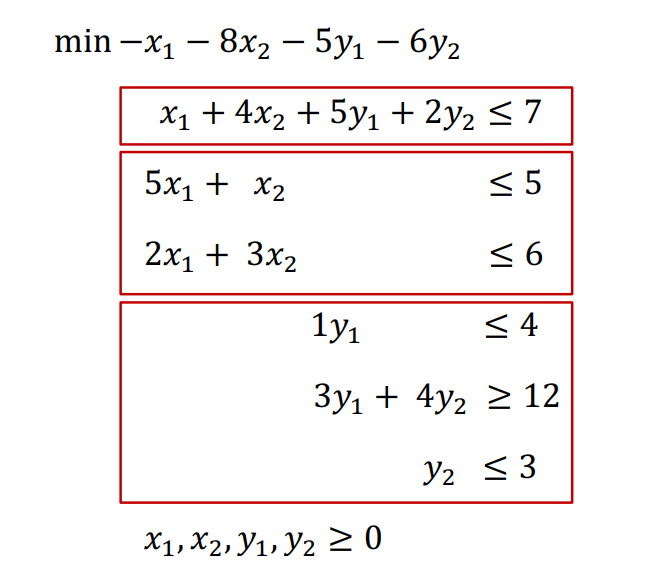

In [2]:
# Given data
C1 = np.array([-1, -8])  # Coefficients for x variables in the master problem
C2 = np.array([-5, -6])  # Coefficients for y variables in the master problem

E1 = np.array([1, 4])    # Coefficients in coupling constraint for x variables
E2 = np.array([5, 2])    # Coefficients in coupling constraint for y variables

initial_X1 = np.array([0, 0])  # Initial solution for x variables
initial_Y1 = np.array([0, 3])  # Initial solution for y variables

In [3]:
def Restricted_Master_Problem():
    
    # Initialize RMP model
    model = pyo.ConcreteModel()
    model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

    # Define initial variables
    model.alpha1 = pyo.Var(within=pyo.NonNegativeReals)
    model.beta1 = pyo.Var(within=pyo.NonNegativeReals)
    model.S = pyo.Var(within=pyo.NonNegativeReals)

    # Objective function
    model.Obj = pyo.Objective(expr=np.dot(C1, initial_X1) * model.alpha1 + np.dot(C2, initial_Y1) * model.beta1, sense=pyo.minimize)

    # Initial constraints
    model.Constraint1 = pyo.Constraint(expr=np.dot(E1, initial_X1) * model.alpha1 + np.dot(E2, initial_Y1) * model.beta1 + model.S == 7)
    model.Constraint2 = pyo.Constraint(expr=model.alpha1 == 1)
    model.Constraint3 = pyo.Constraint(expr=model.beta1 == 1)

    solver = pyo.SolverFactory('glpk')
    
    # ----------------------------------------------------------------------------------------------
    # Initialize iteration trackers
    iteration = 0
    alpha_count = 1
    beta_count = 1
    x_done = False
    y_done = False
    tolerance = 1e-8  # Define tolerance for reduced costs

    # Lists to store subproblem solutions
    x_star_values = []
    y_star_values = []

    while not (x_done and y_done):
        iteration += 1
        print(f"\nIteration {iteration}:")

        # Solve the RMP
        solver.solve(model)

        # Retrieve dual values
        dual_values = [
            model.dual[model.Constraint1],
            model.dual[model.Constraint2],
            model.dual[model.Constraint3]
        ]
        
        # ------------------------------------------------------------------------------------------
        # Subproblem for x variables
        def Subproblem_x(dual_values):
            model_x = pyo.ConcreteModel()
            model_x.x1 = pyo.Var(within=pyo.NonNegativeReals)
            model_x.x2 = pyo.Var(within=pyo.NonNegativeReals)

            # Objective function
            model_x.Obj = pyo.Objective(
                expr=(C1[0] - dual_values[0] * E1[0]) * model_x.x1 + (C1[1] - dual_values[0] * E1[1]) * model_x.x2,
                sense=pyo.minimize,
            )

            # Constraints
            model_x.constraints = pyo.ConstraintList()
            model_x.constraints.add(5 * model_x.x1 + model_x.x2 <= 5)
            model_x.constraints.add(2 * model_x.x1 + 3 * model_x.x2 <= 6)

            solver.solve(model_x)
            x1_star = pyo.value(model_x.x1)
            x2_star = pyo.value(model_x.x2)
            reduced_cost_x = pyo.value(model_x.Obj) - dual_values[1]

            return (x1_star, x2_star), reduced_cost_x
        
        # ------------------------------------------------------------------------------------------
        # Subproblem for y variables
        def Subproblem_y(dual_values):
            model_y = pyo.ConcreteModel()
            model_y.y1 = pyo.Var(within=pyo.NonNegativeReals)
            model_y.y2 = pyo.Var(within=pyo.NonNegativeReals)

            # Objective function
            model_y.Obj = pyo.Objective(
                expr=(C2[0] - dual_values[0] * E2[0]) * model_y.y1 + (C2[1] - dual_values[0] * E2[1]) * model_y.y2,
                sense=pyo.minimize,
            )

            # Constraints
            model_y.constraints = pyo.ConstraintList()
            model_y.constraints.add(model_y.y1 <= 4)
            model_y.constraints.add(model_y.y2 <= 3)
            model_y.constraints.add(3 * model_y.y1 + 4 * model_y.y2 >= 12)

            solver.solve(model_y)
            y1_star = pyo.value(model_y.y1)
            y2_star = pyo.value(model_y.y2)
            reduced_cost_y = pyo.value(model_y.Obj) - dual_values[2]

            return (y1_star, y2_star), reduced_cost_y

        # ------------------------------------------------------------------------------------------
        x_star, reduced_cost_x = Subproblem_x(dual_values) if not x_done else (None, 0)
        y_star, reduced_cost_y = Subproblem_y(dual_values) if not y_done else (None, 0)

        # Treat very small reduced costs as zero
        reduced_cost_x = 0 if abs(reduced_cost_x) < tolerance else reduced_cost_x
        reduced_cost_y = 0 if abs(reduced_cost_y) < tolerance else reduced_cost_y

        print(f"Reduced cost X: {reduced_cost_x}")
        print(f"Reduced cost Y: {reduced_cost_y}")

        # ------------------------------------------------------------------------------------------
        # Update termination conditions
        if reduced_cost_x >= 0:
            x_done = True
        else:
            x_star_values.append(x_star)

        if reduced_cost_y >= 0:
            y_done = True
        else:
            y_star_values.append(y_star)

        # ------------------------------------------------------------------------------------------
        # Add new variables if reduced cost is negative
        if not x_done and reduced_cost_x < 0:
            alpha_count += 1
            new_alpha = pyo.Var(within=pyo.NonNegativeReals)
            model.add_component(f'alpha{alpha_count}', new_alpha)
            model.Obj.expr += np.dot(C1, x_star) * new_alpha
            model.Constraint1.set_value(
                model.Constraint1.body + np.dot(E1, x_star) * new_alpha == 7
            )
            model.Constraint2.set_value(model.Constraint2.body + new_alpha == 1)

        if not y_done and reduced_cost_y < 0:
            beta_count += 1
            new_beta = pyo.Var(within=pyo.NonNegativeReals)
            model.add_component(f'beta{beta_count}', new_beta)
            model.Obj.expr += np.dot(C2, y_star) * new_beta
            model.Constraint1.set_value(
                model.Constraint1.body + np.dot(E2, y_star) * new_beta == 7
            )
            model.Constraint3.set_value(model.Constraint3.body + new_beta == 1)
            
    # ----------------------------------------------------------------------------------------------
    # Final results
    print("\n--------------------")
    print("\nFinal RMP result:")
    print(f"Objective Value: {pyo.value(model.Obj)}")
    
    # Retrieve values of alpha and beta
    alpha_values = [pyo.value(var) for var in model.component_data_objects(pyo.Var) if var.name.startswith("alpha")]
    beta_values = [pyo.value(var) for var in model.component_data_objects(pyo.Var) if var.name.startswith("beta")]

    # Print the values
    for var in model.component_data_objects(pyo.Var):
        print(f"{var.name} = {pyo.value(var)}")
       
    # ----------------------------------------------------------------------------------------------
    # Calculate X and Y
    X = np.zeros(len(C1)) 
    Y = np.zeros(len(C2)) 
    
    for i, alpha in enumerate(alpha_values):
        x_star = initial_X1 if i == 0 else x_star_values[i - 1]
        X += alpha * np.array(x_star)
    
    for j, beta in enumerate(beta_values):
        y_star = initial_Y1 if j == 0 else y_star_values[j - 1]
        Y += beta * np.array(y_star)
    
    print("\n--------------------")
    print("\nFinal calculated values:")
    print(f"X = {X}")
    print(f"Y = {Y}")

In [4]:
# Run the Restricted Master Problem
Restricted_Master_Problem()


Iteration 1:
Reduced cost X: -16.0
Reduced cost Y: -20.0

Iteration 2:
Reduced cost X: 0
Reduced cost Y: 0

--------------------

Final RMP result:
Objective Value: -20.0
alpha1 = 0.875
beta1 = 1.0
S = 0.0
alpha2 = 0.125
beta2 = 0.0

--------------------

Final calculated values:
X = [0.   0.25]
Y = [0. 3.]


# **Dantzig Wolfe for Two Coupling Constraints**

![Optimization Model 2.png](<attachment:Optimization Model 2.png>)
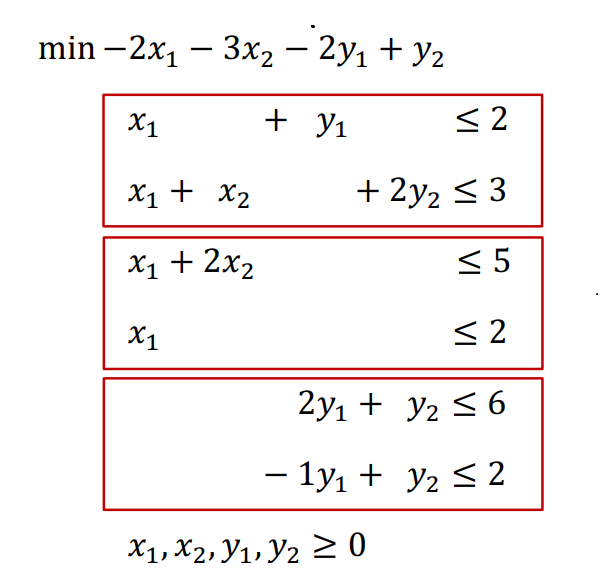

In [5]:
# Given data
C1 = np.array([-2, -3])  # Coefficients for x variables in the master problem
C2 = np.array([-2,  1])  # Coefficients for y variables in the master problem

E1 = np.array([1, 0])    # Coefficients in first coupling constraint for x variables
E2 = np.array([1, 0])    # Coefficients in first coupling constraint for y variables

F1 = np.array([1, 1])    # Coefficients in second coupling constraint for x variables
F2 = np.array([0, 2])    # Coefficients in second coupling constraint for y variables

initial_X1 = np.array([0, 0])  # Initial solution for x variables
initial_Y1 = np.array([0, 0])  # Initial solution for y variables

In [6]:
def Restricted_Master_Problem():
    
    # Initialize RMP model
    model = pyo.ConcreteModel()
    model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

    # Define initial variables
    model.alpha1 = pyo.Var(within=pyo.NonNegativeReals)
    model.beta1 = pyo.Var(within=pyo.NonNegativeReals)
    model.S1 = pyo.Var(within=pyo.NonNegativeReals)
    model.S2 = pyo.Var(within=pyo.NonNegativeReals)

    # Objective function
    model.Obj = pyo.Objective(expr=np.dot(C1, initial_X1) * model.alpha1 + np.dot(C2, initial_Y1) * model.beta1, sense=pyo.minimize)

    # Initial constraints
    model.Constraint1 = pyo.Constraint(expr=np.dot(E1, initial_X1) * model.alpha1 + np.dot(E2, initial_Y1) * model.beta1 + model.S1 == 2)
    model.Constraint2 = pyo.Constraint(expr=np.dot(F1, initial_X1) * model.alpha1 + np.dot(F2, initial_Y1) * model.beta1 + model.S2 == 3)
    model.Constraint3 = pyo.Constraint(expr=model.alpha1 == 1)
    model.Constraint4 = pyo.Constraint(expr=model.beta1 == 1)

    solver = pyo.SolverFactory('glpk')
    
    # ----------------------------------------------------------------------------------------------
    # Initialize iteration trackers
    iteration = 0
    alpha_count = 1
    beta_count = 1
    x_done = False
    y_done = False
    tolerance = 1e-8  # Define tolerance for reduced costs

    # Lists to store subproblem solutions
    x_star_values = []
    y_star_values = []

    while not (x_done and y_done):
        iteration += 1
        print(f"\nIteration {iteration}:")

        # Solve the RMP
        solver.solve(model)

        # Retrieve dual values
        dual_values = [
            model.dual[model.Constraint1],
            model.dual[model.Constraint2],
            model.dual[model.Constraint3],
            model.dual[model.Constraint4]
        ]
        
        # ------------------------------------------------------------------------------------------
        # Subproblem for x variables
        def Subproblem_x(dual_values):
            model_x = pyo.ConcreteModel()
            model_x.x1 = pyo.Var(within=pyo.NonNegativeReals)
            model_x.x2 = pyo.Var(within=pyo.NonNegativeReals)

            # Objective function
            model_x.Obj = pyo.Objective(
                expr=(C1[0] - dual_values[0] * E1[0] - dual_values[1] * F1[0]) * model_x.x1 + (C1[1] - dual_values[0] * E1[1] - dual_values[1] * F1[1]) * model_x.x2,
                sense=pyo.minimize,
            )

            # Constraints
            model_x.constraints = pyo.ConstraintList()
            model_x.constraints.add(1 * model_x.x1 + 2 * model_x.x2 <= 5)
            model_x.constraints.add(1 * model_x.x1 + 0 * model_x.x2 <= 2)

            solver.solve(model_x)
            x1_star = pyo.value(model_x.x1)
            x2_star = pyo.value(model_x.x2)
            reduced_cost_x = pyo.value(model_x.Obj) - dual_values[2]

            return (x1_star, x2_star), reduced_cost_x
        
        # ------------------------------------------------------------------------------------------
        # Subproblem for y variables
        def Subproblem_y(dual_values):
            model_y = pyo.ConcreteModel()
            model_y.y1 = pyo.Var(within=pyo.NonNegativeReals)
            model_y.y2 = pyo.Var(within=pyo.NonNegativeReals)

            # Objective function
            model_y.Obj = pyo.Objective(
                expr=(C2[0] - dual_values[0] * E2[0] - dual_values[1] * F2[0]) * model_y.y1 + (C2[1] - dual_values[0] * E2[1] - dual_values[1] * F2[1]) * model_y.y2,
                sense=pyo.minimize,
            )

            # Constraints
            model_y.constraints = pyo.ConstraintList()
            model_y.constraints.add(+2 * model_y.y1 + 1 * model_y.y2 <= 6)
            model_y.constraints.add(-1 * model_y.y1 + 1 * model_y.y2 <= 2)

            solver.solve(model_y)
            y1_star = pyo.value(model_y.y1)
            y2_star = pyo.value(model_y.y2)
            reduced_cost_y = pyo.value(model_y.Obj) - dual_values[3]

            return (y1_star, y2_star), reduced_cost_y

        # ------------------------------------------------------------------------------------------
        x_star, reduced_cost_x = Subproblem_x(dual_values) if not x_done else (None, 0)
        y_star, reduced_cost_y = Subproblem_y(dual_values) if not y_done else (None, 0)

        # Treat very small reduced costs as zero
        reduced_cost_x = 0 if abs(reduced_cost_x) < tolerance else reduced_cost_x
        reduced_cost_y = 0 if abs(reduced_cost_y) < tolerance else reduced_cost_y

        print(f"Reduced cost X: {reduced_cost_x}")
        print(f"Reduced cost Y: {reduced_cost_y}")

        # ------------------------------------------------------------------------------------------
        # Update termination conditions
        if reduced_cost_x >= 0:
            x_done = True
        else:
            x_star_values.append(x_star)

        if reduced_cost_y >= 0:
            y_done = True
        else:
            y_star_values.append(y_star)

        # ------------------------------------------------------------------------------------------
        # Add new variables if reduced cost is negative
        if not x_done and reduced_cost_x < 0:
            alpha_count += 1
            new_alpha = pyo.Var(within=pyo.NonNegativeReals)
            model.add_component(f'alpha{alpha_count}', new_alpha)
            model.Obj.expr += np.dot(C1, x_star) * new_alpha
            model.Constraint1.set_value(
                model.Constraint1.body + np.dot(E1, x_star) * new_alpha == 2
            )
            model.Constraint2.set_value(
                model.Constraint2.body + np.dot(F1, x_star) * new_alpha == 3
            )
            model.Constraint3.set_value(model.Constraint3.body + new_alpha == 1)

        if not y_done and reduced_cost_y < 0:
            beta_count += 1
            new_beta = pyo.Var(within=pyo.NonNegativeReals)
            model.add_component(f'beta{beta_count}', new_beta)
            model.Obj.expr += np.dot(C2, y_star) * new_beta
            model.Constraint1.set_value(
                model.Constraint1.body + np.dot(E2, y_star) * new_beta == 2
            )
            model.Constraint2.set_value(
                model.Constraint2.body + np.dot(F2, y_star) * new_beta == 3
            )
            model.Constraint4.set_value(model.Constraint4.body + new_beta == 1)
            
    # ----------------------------------------------------------------------------------------------
    # Final results
    print("\n--------------------")
    print("\nFinal RMP result:")
    print(f"Objective Value: {pyo.value(model.Obj)}")
    
    # Retrieve values of alpha and beta
    alpha_values = [pyo.value(var) for var in model.component_data_objects(pyo.Var) if var.name.startswith("alpha")]
    beta_values = [pyo.value(var) for var in model.component_data_objects(pyo.Var) if var.name.startswith("beta")]

    # Print the values
    for var in model.component_data_objects(pyo.Var):
        print(f"{var.name} = {pyo.value(var)}")
                
    # ----------------------------------------------------------------------------------------------
    # Calculate X and Y
    X = np.zeros(len(C1)) 
    Y = np.zeros(len(C2)) 
    
    for i, alpha in enumerate(alpha_values):
        x_star = initial_X1 if i == 0 else x_star_values[i - 1]
        X += alpha * np.array(x_star)
    
    for j, beta in enumerate(beta_values):
        y_star = initial_Y1 if j == 0 else y_star_values[j - 1]
        Y += beta * np.array(y_star)
    
    print("\n--------------------")
    print("\nFinal calculated values:")
    print(f"X = {X}")
    print(f"Y = {Y}")

In [7]:
# Run the Restricted Master Problem
Restricted_Master_Problem()


Iteration 1:
Reduced cost X: -8.5
Reduced cost Y: -6.0

Iteration 2:
Reduced cost X: -4.285714285714275
Reduced cost Y: 0

Iteration 3:
Reduced cost X: 0
Reduced cost Y: 0

--------------------

Final RMP result:
Objective Value: -11.500000000000002
alpha1 = 0.0
beta1 = 0.333333333333333
S1 = 0.0
S2 = 0.5
alpha2 = 0.0
beta2 = 0.666666666666667
alpha3 = 1.0

--------------------

Final calculated values:
X = [0.  2.5]
Y = [2. 0.]
